In [139]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

In [140]:
# bacalah file `googleplaystore.csv` data dan simpan ke objek dataframe dengan nama playstore
playstore = pd.read_csv('data/googleplaystore.csv')

In [141]:
# Hapus data yang duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)
playstore1 = playstore.drop_duplicates(subset = 'App', keep= 'first', inplace=True)

In [142]:
# bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar
playstore.drop([10472], inplace=True)

In [143]:
# Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai
playstore.Category = playstore['Category'].astype('category')

In [144]:
# Pada kolom Installs Buang tanda koma(,) dan tanda tambah(+) kemudian ubah tipe data menjadi integer
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',',''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+',''))

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: object

In [145]:
playstore[['Installs']] = playstore[['Installs']].astype('int64')

In [146]:
# Bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)

In [147]:
# Pada kolom Price, buang karakater $ pada nilai Price lalu ubah tipe datanya menjadi float
playstore.Price = playstore.Price.apply(lambda x: x.replace('$',''))
playstore[['Price']] = playstore[['Price']].astype('float64')

In [148]:
playstore.dtypes

App                 object
Category          category
Rating             float64
Reviews             object
Size               float64
Installs             int64
Type                object
Price              float64
Content Rating      object
Genres              object
Last Updated        object
Current Ver         object
Android Ver         object
dtype: object

In [149]:
# Ubah tipe data Reviews, Size, Installs ke dalam tipe data integer
playstore[['Reviews','Size']] = playstore[['Reviews','Size']].astype('int64')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [150]:
df2 = playstore.copy()

In [151]:
# Statistik
    # Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap Category. 
    # Gunakan crosstab untuk menghitung frekuensi aplikasi di setiap category kemudian gunakan 'Jumlah'
    # sebagai nama kolom dan urutkan nilai frekuensi dari nilai yang paling banyak. Terakhir reset index dari dataframe top_category 
top_category = pd.crosstab(
    index=df2['Category'],
    columns='Jumlah',
).sort_values(by='Jumlah', ascending=False).reset_index()

top_category

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395
5,PERSONALIZATION,376
6,PRODUCTIVITY,374
7,LIFESTYLE,369
8,FINANCE,345
9,SPORTS,325


In [152]:
# Dictionary stats digunakan untuk menyimpan beberapa data yang digunakan untuk menampilkan nilai di value box dan tabel

        # Ini adalah bagian untuk melengkapi konten value box 
        # most category mengambil nama category paling banyak mengacu pada dataframe top_category
        # total mengambil frekuensi/jumlah category paling banyak mengacu pada dataframe top_category
most_categories = top_category['Category'][0]
total = top_category['Jumlah'][0]

In [153]:
 # rev_table adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna. 
        # Silahkan melakukan agregasi data yang tepat menggunakan groupby untuk menampilkan 10 aplikasi yang diurutkan berdasarkan 
        # jumlah Review pengguna. Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama Category, nama App, total Reviews, dan rata-rata Rating.
        # Agregasi Anda dinilai benar jika hasilnya sama dengan tabel yang terlampir pada file ini
        
rev_table = df2[['Category','App','Reviews','Rating']].groupby(['Category','App']).agg({
    'Reviews':'sum', 
    'Rating':'mean'
}).sort_values(by='Reviews', ascending=False).head(10).reset_index()
rev_table

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306.0,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316.0,4.4
2,SOCIAL,Instagram,66577313.0,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847.0,4.0
4,GAME,Clash of Clans,44891723.0,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526.0,4.7
6,GAME,Subway Surfers,27722264.0,4.5
7,VIDEO_PLAYERS,YouTube,25655305.0,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999.0,4.7
9,GAME,Clash Royale,23133508.0,4.6


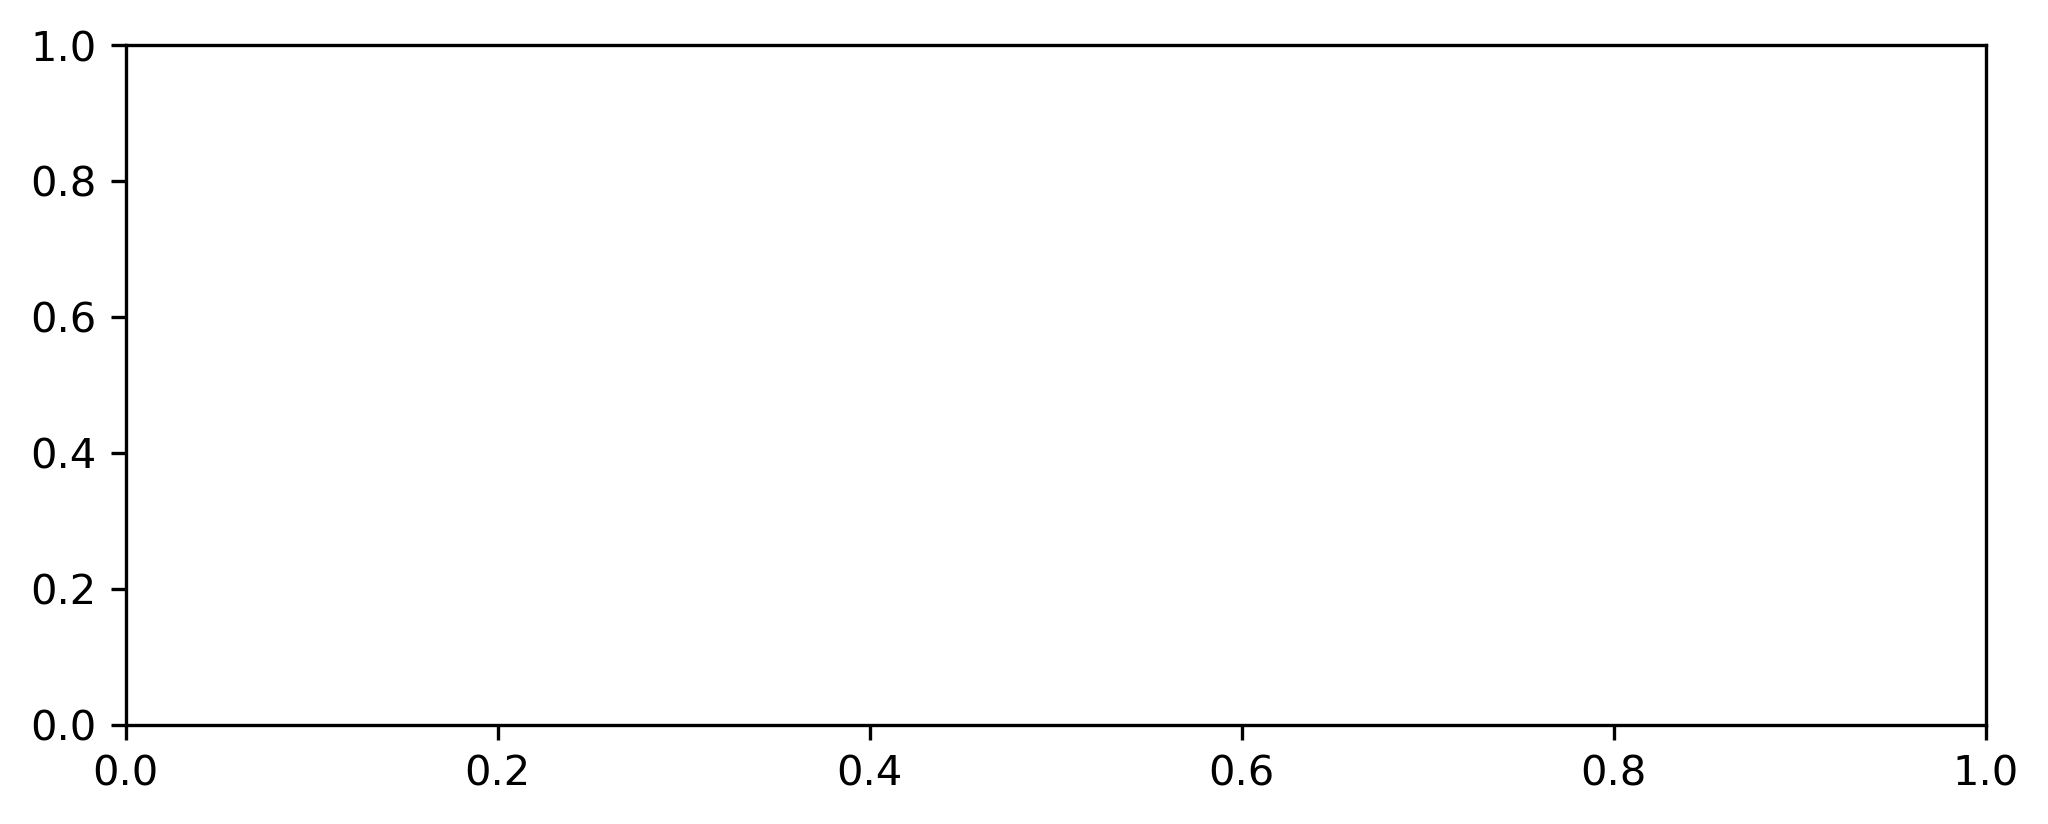

In [189]:
## Bar Plot
    ## Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan aplikasi berdasarkan Category
    ## Buatlah bar plot dimana axis x adalah nama Category dan axis y adalah jumlah aplikasi pada setiap kategori, kemudian urutkan dari jumlah terbanyak
cat_order = df2.groupby(['Category']).agg({
    'Category' : 'count'
}).rename({'Category':'Total'}, axis=1).sort_values(by='Total', ascending=False).head().reset_index()
X = cat_order['Category']
Y = cat_order['Total']
my_colors = 'rgbkymc'
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()

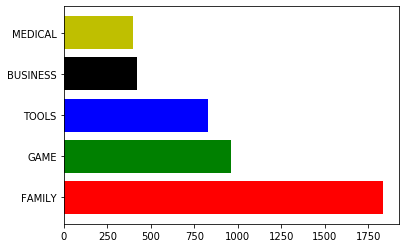

In [176]:
# bagian ini digunakan untuk membuat bar plot
    # isi variabel x dan y yang telah di definisikan di atas
plt.barh(X,Y, color=my_colors)

# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight")

In [178]:
# bagian ini digunakan untuk mengconvert matplotlib png ke base64 agar dapat ditampilkan ke template html
figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
# variabel result akan dimasukkan ke dalam parameter di fungsi render_template() agar dapat ditampilkan di 
# halaman html
result = str(figdata_png)[2:-1]

<Figure size 432x288 with 0 Axes>

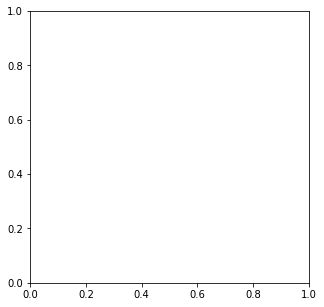

In [181]:
## Scatter Plot
# Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating.
# Ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()

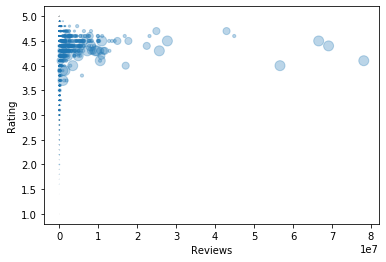

In [185]:
# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=df2['Reviews'],y=df2['Rating'], s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result2 = str(figdata_png)[2:-1]

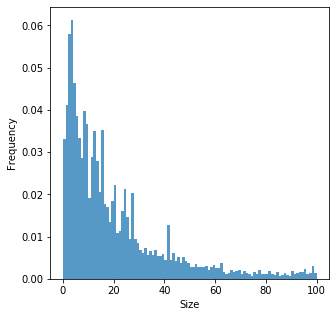

In [187]:
## Histogram Size Distribution
# Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes) 
# Histogram yang terbentuk terbagi menjadi 100 bins
X=(playstore.Size/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result3 = str(figdata_png)[2:-1]

In [201]:
## Buatlah sebuah plot yang menampilkan insight di dalam data 

family = df2[df2['Category'] == 'FAMILY']
family

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2017,Jewels Crush- Match 3 Puzzle,FAMILY,4.4,14774,19000000,1000000,Free,0.0,Everyone,Casual;Brain Games,"July 23, 2018",1.9.3901,4.0.3 and up
2018,Coloring & Learn,FAMILY,4.4,12753,51000000,5000000,Free,0.0,Everyone,Educational;Creativity,"July 17, 2018",1.49,4.0.3 and up
2019,Mahjong,FAMILY,4.5,33983,22000000,5000000,Free,0.0,Everyone,Puzzle;Brain Games,"August 2, 2018",1.24.3181,4.0.3 and up
2020,Super ABC! Learning games for kids! Preschool ...,FAMILY,4.6,20267,46000000,1000000,Free,0.0,Everyone,Educational;Education,"July 16, 2018",1.1.6.7,4.1 and up
2021,Toy Pop Cubes,FAMILY,4.5,5761,21000000,1000000,Free,0.0,Everyone,Casual;Brain Games,"July 4, 2018",1.8.3181,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,Poop FR,FAMILY,NaN,6,2500000,50,Free,0.0,Everyone,Entertainment,"May 29, 2018",1.0,4.0.3 and up
10827,Fr Agnel Ambarnath,FAMILY,4.2,117,13000000,5000,Free,0.0,Everyone,Education,"June 13, 2018",2.0.20,4.0.3 and up
10834,FR Calculator,FAMILY,4.0,7,2600000,500,Free,0.0,Everyone,Education,"June 18, 2017",1.0.0,4.1 and up
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53000000,5000,Free,0.0,Everyone,Education,"July 25, 2017",1.48,4.1 and up


C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ASUS\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


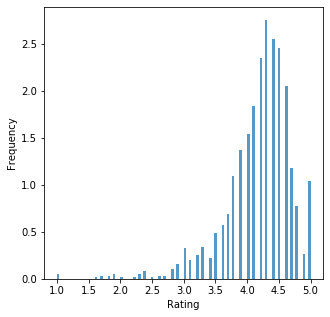

In [203]:
X=(family.Rating).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

figfile = BytesIO()
plt.savefig(figfile, format='png')
figfile.seek(0)
figdata_png = base64.b64encode(figfile.getvalue())
result4 = str(figdata_png)[2:-1]

In [ ]:
# Tambahkan hasil result plot pada fungsi render_template()
    return render_template('index.html', stats=stats, result=result, result2=result2, result3=result3)

if __name__ == "__main__": 
    app.run(debug=True)